<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
<a href="https://sebastianraschka.com">Sebastian Raschka</a>의 저서 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>를 위한 보충 코드<br>
<br>코드 저장소: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="images/llm_from_scratch/dpo/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# LLM 정렬을 위한 DPO(Direct Preference Optimization) 구현 (밑바닥부터 시작하기)

- 이 코드 노트북은 DPO(Direct Preference Optimization)를 처음부터 구현하고 이를 대규모 언어 모델(LLM)에 적용하여 사용자 선호도에 더 부합하는 응답을 생성하도록 모델 성능을 향상시키는 방법을 다룹니다.

In [1]:
from importlib.metadata import version

pkgs = [
    "tiktoken",    # 토크나이저 (Tokenizer)
    "torch",       # 딥러닝 라이브러리 (Deep learning library)
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

tiktoken version: 0.12.0
torch version: 2.9.1+cu126


&nbsp;
# 1) DPO에 대한 간략한 소개

- 논문 [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290)에서 제안된 DPO는 LLM 미세 튜닝(finetuning)에 사용되는 인간 피드백 기반 강화 학습(RLHF)의 대안입니다.
- DPO는 모델을 미세 튜닝(또는 정렬, align)하여 사용자의 기대와 지시에 더 잘 맞는 응답을 생성하도록 하는 데 사용될 수 있습니다.

<img src="images/llm_from_scratch/dpo/1.webp" width=500px>

- 지시 튜닝(Instruction finetuning)에서는 프롬프트가 주어졌을 때 올바른 답변을 생성하도록 LLM을 훈련합니다.
- 하지만 실제로는 정답을 제시하는 방법이 여러 가지일 수 있으며, 정답의 스타일도 다를 수 있습니다. 예를 들어, 아래 그림처럼 LLM에게 노트북 구매 추천을 요청할 때 기술적인 답변과 사용자 친화적인 답변을 비교해 볼 수 있습니다.

<img src="images/llm_from_scratch/dpo/2.webp" width=700px>

- RLHF와 DPO는 LLM이 특정 답변 스타일을 다른 스타일보다 선호하도록, 즉 사용자 선호도에 더 잘 맞추도록 가르치는 데 사용할 수 있는 방법입니다.
- 별도의 보상 모델(reward model)을 훈련해야 하는 RLHF 프로세스는 아래와 같습니다.

<img src="images/llm_from_scratch/dpo/4.webp" width=600px>

- RLHF와 비교했을 때, DPO는 복잡한 보상 모델링이나 정책 최적화(policy optimization) 과정 없이 사용자 선호도에 맞춰 모델을 직접 최적화함으로써 프로세스를 단순화하는 것을 목표로 합니다.
- 다시 말해, DPO는 인간의 선호도나 특정 목표에 부합하도록 모델의 출력을 직접 최적화하는 데 중점을 둡니다.
- 아래 그림은 DPO의 작동 원리에 대한 개요를 보여줍니다.

<img src="images/llm_from_scratch/dpo/5.webp" width=600px>

- DPO 손실(loss)을 구현하기 위한 구체적인 수식은 아래와 같습니다. 이 수식은 이 노트북의 뒷부분에서 Python으로 구현할 때 다시 살펴보겠습니다.

<img src="images/llm_from_scratch/dpo/3.webp" width=600px>

- 위 식에서,
  - "기댓값(expected value)" $\mathbb{E}$는 통계 용어로 확률 변수(괄호 안의 표현식)의 평균값을 의미합니다. $-\mathbb{E}$를 최적화하면 모델이 사용자 선호도에 더 잘 부합하게 됩니다.
  - $\pi_{\theta}$ 변수는 소위 정책(policy, 강화 학습에서 차용한 용어)이라 불리며 우리가 최적화하고자 하는 LLM을 나타냅니다. $\pi_{ref}$는 참조(reference) LLM으로, 일반적으로 최적화 전의 원본 LLM입니다 (훈련 시작 시점에는 $\pi_{\theta}$와 $\pi_{ref}$가 보통 동일합니다).
  - $\beta$는 $\pi_{\theta}$와 참조 모델 간의 발산(divergence)을 제어하는 하이퍼파라미터입니다. $\beta$를 높이면 전체 손실 함수에서 $\pi_{\theta}$와 $\pi_{ref}$의 로그 확률 차이가 미치는 영향이 줄어들어, 두 모델 간의 차이(divergence)가 감소합니다.
  - 로지스틱 시그모이드 함수 $\sigma(\centerdot)$는 선호되는 응답과 거부되는 응답의 로그 오즈(log-odds, 시그모이드 함수 내부의 항)를 확률 점수로 변환합니다.
- 코드 노트북이 너무 방대해지는 것을 피하기 위해, 이 개념들에 대한 더 자세한 논의는 향후 별도의 기사로 작성할 예정입니다.
- 그동안 RLHF와 DPO의 비교에 관심이 있다면, 제 기사 [Tips for LLM Pretraining and Evaluating Reward Models](https://magazine.sebastianraschka.com/p/tips-for-llm-pretraining-and-evaluating-rms)의 [2.2. RLHF vs Direct Preference Optimization (DPO)](https://magazine.sebastianraschka.com/i/142924793/rlhf-vs-direct-preference-optimization-dpo) 섹션을 참조하세요.

&nbsp;
# 2) DPO를 위한 선호도 데이터셋 준비

- 데이터셋을 로드하고 준비하는 것으로 시작해 보겠습니다. 이 과정을 통해 DPO 손실 수식을 다시 살펴보기 전에 가질 수 있는 많은 질문이 해결될 것입니다.
- 여기서 우리는 지시 프롬프트에 대해 더 정중한 응답과 덜 정중한 응답이 포함된 데이터셋을 사용합니다(구체적인 예시는 다음 섹션에 나와 있습니다).
- 이 데이터셋은 [create-preference-data-ollama.ipynb](create-preference-data-ollama.ipynb) 노트북을 통해 생성되었습니다.

&nbsp;
## 2.1) 선호도 데이터셋 로드하기

- 이 데이터셋은 1,100개의 항목이 있는 json 파일입니다:

In [2]:
import json
import os
import requests


def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    data = json.loads(text_data)
    return data


file_path = "datas/instruction-data-with-preference.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/04_preference-tuning-with-dpo/instruction-data-with-preference.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- 두 개의 예시 항목을 살펴보겠습니다:

In [3]:
import pprint

pprint.pp(data[50])

{'instruction': 'Identify the correct spelling of the following word.',
 'input': 'Ocassion',
 'output': "The correct spelling is 'Occasion.'",
 'rejected': "The correct spelling is obviously 'Occasion.'",
 'chosen': "The correct spelling is 'Occasion.'"}


In [4]:
pprint.pp(data[999])

{'instruction': "What is an antonym of 'complicated'?",
 'input': '',
 'output': "An antonym of 'complicated' is 'simple'.",
 'chosen': "A suitable antonym for 'complicated' would be 'simple'.",
 'rejected': "An antonym of 'complicated' is 'simple'."}




```
# This is formatted as code
```

- 위에서 볼 수 있듯이 데이터셋은 5개의 키로 구성되어 있습니다:
    - `'instruction'`과 `'input'`은 LLM 입력으로 사용됩니다.
    - `'output'`은 7장에서 지시 튜닝 단계를 통해 훈련된 모델의 응답을 포함합니다.
    - `'chosen'`과 `'rejected'` 항목은 DPO에 사용하는 항목입니다. 여기서 `'chosen'`은 선호되는 응답(preferred)이고, `'rejected'`는 거부되는 응답(dispreferred)입니다.
- 목표는 모델이 거부된 응답 대신 선택된 응답의 스타일을 따르도록 하는 것입니다.

- 아래는 7장([../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb))과 유사하게 Alpaca 프롬프트 스타일을 적용하여 모델 입력을 포맷팅하는 유틸리티 함수입니다:

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


- 마찬가지로 Alpaca 프롬프트 스타일을 사용하여 선호 응답과 거부 응답을 포맷팅할 수 있습니다:

In [7]:
desired_response = f"### Response:\n{data[50]['chosen']}"
print(desired_response)

### Response:
The correct spelling is 'Occasion.'


In [8]:
possible_response = f"### Response:\n{data[50]['rejected']}"
print(possible_response)

### Response:
The correct spelling is obviously 'Occasion.'


&nbsp;
## 2.2) 훈련, 검증 및 테스트 분할 생성

- 다음으로 데이터셋을 훈련 데이터 85%, 검증 데이터 5%, 테스트 데이터 10%의 세 부분으로 나눕니다:

In [9]:
train_portion = int(len(data) * 0.85)  # 85%는 훈련용 (85% for training)
test_portion = int(len(data) * 0.1)    # 10%는 테스트용 (10% for testing)
val_portion = len(data) - train_portion - test_portion  # 나머지 5%는 검증용 (Remaining 5% for validation)

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [10]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


&nbsp;
## 2.3) `PreferenceDataset` 클래스와 배치 처리 함수 개발

- 이 섹션에서는 7장([../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb))의 `InstructionDataset` 클래스를 DPO에 맞게 재작성합니다.
- 즉, 단일 출력 시퀀스(응답)에 초점을 맞추는 대신, 하나가 다른 것보다 선호되는("chosen") 한 쌍의 응답(다른 하나는 "rejected")을 반환하도록 데이터셋 클래스를 수정합니다.
- 전반적으로 `PreferenceDataset`은 7장에서 사용된 `InstructionDataset`과 거의 동일합니다:

In [ ]:
import torch
from torch.utils.data import Dataset

class PreferenceDataset(Dataset):
    """
    선호도(Preference) 학습을 위한 데이터셋 클래스입니다.
    DPO나 Reward Model 학습 시 사용되며, 
    하나의 질문에 대해 '선택된 답변(Chosen)'과 '거부된 답변(Rejected)' 쌍을 다룹니다.
    """
    def __init__(self, data, tokenizer):
        self.data = data

        # 데이터를 미리 모두 토큰화해서 메모리에 올려둡니다 (속도 향상)
        self.encoded_texts = []
        
        for entry in data:
            # 1. 질문(Prompt) 포맷팅
            prompt = format_input(entry)
            
            # 2. 데이터에서 승리한 답변(Chosen)과 패배한 답변(Rejected) 추출
            rejected_response = entry["rejected"]
            chosen_response = entry["chosen"]

            # 3. 토큰화 진행 (세 가지를 준비합니다)
            
            # (1) 프롬프트(질문) 부분만 별도로 토큰화 
            # -> 나중에 Loss 계산 시 질문 부분은 정답에서 제외(마스킹)하기 위해 길이 정보가 필요할 수 있습니다.
            prompt_tokens = tokenizer.encode(prompt)
            
            # (2) [질문 + 좋은 답변] 전체 텍스트 생성 및 토큰화
            chosen_full_text = f"{prompt}\n\n### Response:\n{chosen_response}"
            chosen_full_tokens = tokenizer.encode(chosen_full_text)
            
            # (3) [질문 + 나쁜 답변] 전체 텍스트 생성 및 토큰화
            rejected_full_text = f"{prompt}\n\n### Response:\n{rejected_response}"
            rejected_full_tokens = tokenizer.encode(rejected_full_text)

            # 4. 딕셔너리 형태로 저장
            # 나중에 collate_fn에서 꺼내 쓸 때 명확하게 구분하기 위함입니다.
            self.encoded_texts.append({
                "prompt": prompt_tokens,      # 질문 토큰들
                "chosen": chosen_full_tokens, # 질문 + 좋은 답변 토큰들
                "rejected": rejected_full_tokens, # 질문 + 나쁜 답변 토큰들
            })

    def __getitem__(self, index):
        """
        인덱스에 해당하는 데이터 딕셔너리를 반환합니다.
        예: {'prompt': [...], 'chosen': [...], 'rejected': [...]}
        """
        return self.encoded_texts[index]

    def __len__(self):
        """전체 데이터 개수 반환"""
        return len(self.data)

- 업데이트된 `PreferenceDataset` 클래스와 함께, 각 배치의 시퀀스를 동일한 길이로 패딩(pad)하여 배치 단위로 조립할 수 있게 해주는 업데이트된 배치 콜레이션(collation) 함수도 필요합니다.
- 프로세스를 설명하기 위해 아래 코드에 주석을 추가했습니다. 하지만 아래의 예시 입력과 출력을 보면 어떻게 작동하는지 이해하기 가장 쉬울 것입니다:

In [ ]:
import torch

def custom_collate_fn(
    batch,
    pad_token_id=50256,
    allowed_max_length=None,
    mask_prompt_tokens=True,
    device="cpu"
):
    """
    DPO/RLHF 학습을 위한 배치 처리 함수입니다.
    Chosen(선호)과 Rejected(비선호) 응답을 패딩하고,
    Loss 계산 시 '질문(Prompt)'과 '패딩' 부분을 무시하도록 마스크를 생성합니다.
    """
    
    # 1. 배치 데이터를 담을 딕셔너리 초기화
    # 나중에 텐서로 변환하여 모델에 입력됩니다.
    batch_data = {
        "prompt": [],
        "chosen": [],
        "rejected": [],
        "rejected_mask": [],
        "chosen_mask": []
    }

    # 2. 공통 최대 길이(Global Max Length) 찾기
    # Chosen과 Rejected 데이터 중 가장 긴 문장을 기준으로 패딩 길이를 정합니다.
    # (+1은 EOS 토큰 등을 위한 여유분일 수 있습니다)
    max_length_common = 0
    if batch:
        for key in ["chosen", "rejected"]:
            # 배치 내의 모든 아이템을 순회하며 가장 긴 길이를 갱신
            current_max = max(len(item[key]) + 1 for item in batch)
            max_length_common = max(max_length_common, current_max)

    # 3. 배치의 각 항목(샘플) 처리 루프
    for item in batch:
        # 프롬프트(질문)는 길이를 계산하거나 참조용으로 저장 (Loss 계산엔 직접 안 쓰임)
        prompt = torch.tensor(item["prompt"])
        batch_data["prompt"].append(prompt)

        # Chosen과 Rejected 각각에 대해 패딩 및 마스킹 처리
        for key in ["chosen", "rejected"]:
            sequence = item[key]
            
            # (1) 패딩(Padding): 공통 최대 길이만큼 뒤쪽을 pad_token_id로 채움
            padded = sequence + [pad_token_id] * (max_length_common - len(sequence))
            
            # (2) 마스크 초기화: 일단 모든 위치를 1(True, 학습 함)로 설정
            mask = torch.ones(len(padded)).bool()

            # (3) 패딩 마스킹: 실제 데이터가 끝난 뒤쪽(패딩 영역)은 0(False, 학습 안 함)으로 설정
            mask[len(sequence):] = False

            # (4) 프롬프트 마스킹 (DPO의 핵심!)
            # 질문(Prompt) 부분은 모델이 이미 알고 있는 내용이므로, 
            # 모델이 생성해야 할 '답변' 부분만 학습하기 위해 앞부분을 가립니다.
            if mask_prompt_tokens:
                # prompt.shape[0] : 질문의 길이
                # +2 : "\n\n" 같은 구분자나 포맷팅용 특수 문자까지 포함해서 가리기 위함
                mask[:prompt.shape[0] + 2] = False

            # 처리된 데이터와 마스크를 리스트에 추가
            batch_data[key].append(torch.tensor(padded))
            batch_data[f"{key}_mask"].append(mask)

    # 4. 텐서 변환 및 후처리
    for key in ["chosen", "rejected", "chosen_mask", "rejected_mask"]:
        # 리스트에 담긴 텐서들을 하나로 쌓음 (Batch화)
        tensor_stack = torch.stack(batch_data[key])

        # (선택 사항) 만약 설정된 최대 길이(allowed_max_length)가 있다면 자름(Truncate)
        # 예: GPU 메모리 부족 방지
        if allowed_max_length is not None:
            tensor_stack = tensor_stack[:, :allowed_max_length]

        # 최종 텐서를 지정된 장치(GPU/CPU)로 이동
        batch_data[key] = tensor_stack.to(device)

    return batch_data

- 커스텀 콜레이트(collate) 함수를 사용하기 전에, 함수의 인수 중 일부를 미리 채운 버전을 만들어 보겠습니다:

In [ ]:
import torch
from functools import partial

# ============================================================
# 1. 학습 장치(Device) 자동 설정
# ============================================================

# NVIDIA GPU(CUDA)가 사용 가능한지 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
# GPU가 없으면 기본 CPU 사용
else:
    device = torch.device("cpu")

print("Device:", device)


# ============================================================
# 2. Collate 함수 설정 고정 (Partial Application)
# ============================================================

# 'partial'은 함수의 특정 인자값들을 미리 고정시켜 새로운 함수를 만드는 도구입니다.
# DataLoader는 'batch'라는 인자 하나만 받는 함수를 원하기 때문에,
# 나머지 복잡한 설정(device, length 등)을 미리 채워넣습니다.
customized_collate_fn = partial(
    custom_collate_fn,          # 원래 정의했던 함수
    device=device,              # 위에서 결정된 장치 (데이터를 자동으로 GPU로 올림)
    mask_prompt_tokens=True,    # 프롬프트 마스킹 기능 활성화 (DPO/RLHF용)
    allowed_max_length=1024     # 데이터가 너무 길면 1024 토큰에서 자름 (OOM 방지)
)

# 이제 'customized_collate_fn'은 'batch' 데이터만 넣으면 동작하는 함수가 되었습니다.
# DataLoader(..., collate_fn=customized_collate_fn) 형태로 바로 사용할 수 있습니다.

Device: cuda


- 이제 `customized_collate_fn`이 작동하는 모습을 확인하기 위해 선호도 데이터셋의 샘플 데이터에 적용해 보겠습니다. 이를 위해 처음 두 개의 항목을 가져옵니다:

In [14]:
example_data = data[:2]

for i in example_data:
    print()
    pprint.pp(i)


{'instruction': 'Evaluate the following phrase by transforming it into the '
                'spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".',
 'rejected': 'The spelling of the given phrase "freind" is flat out wrong, get '
             'it together, the correct spelling is "friend".',
 'chosen': 'The spelling of the given phrase "freind" is incorrect, the '
           'correct spelling is "friend".'}

{'instruction': 'Edit the following sentence for grammar.',
 'input': 'He go to the park every day.',
 'output': 'He goes to the park every day.',
 'rejected': 'He goes to the stupid park every single day.',
 'chosen': 'He goes to the park every day.'}


- 다음으로, `example_dataset`을 인스턴스화하고 PyTorch `DataLoader`를 사용하여 나중에 모델 훈련에 사용할 데이터 로더를 모방한 `example_dataloader`를 생성합니다:

In [15]:
import tiktoken
from torch.utils.data import DataLoader


tokenizer = tiktoken.get_encoding("gpt2")

example_dataset = PreferenceDataset(example_data, tokenizer)

example_dataloader = DataLoader(
    example_dataset,
    batch_size=2,
    collate_fn=customized_collate_fn,
    shuffle=False
)

- 데이터셋에는 다음과 같은 키(key)들이 있습니다:

In [16]:
for batch in example_dataloader:
    break

print("batch.keys:", batch.keys())

batch.keys: dict_keys(['prompt', 'chosen', 'rejected', 'rejected_mask', 'chosen_mask'])


- 프롬프트(prompt)는 텐서 리스트이며, 각 텐서에는 해당 예시에 대한 토큰 ID가 포함되어 있습니다. 배치 크기를 2로 선택했으므로 여기에는 두 개의 토큰 ID 텐서 리스트가 있습니다:

In [17]:
batch["prompt"]

[tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545]),
 tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110,    13])]

- 훈련 시 응답(response) 자체가 반드시 필요한 것은 아닙니다. 훈련 중 모델에 제공해야 할 것은 `"chosen"` 및 `"rejected"` 항목입니다.
- `"chosen"` 및 `"rejected"` 응답 항목은 텐서로 쌓을 수 있도록 패딩(pad) 처리됩니다. 프롬프트와 마찬가지로 이러한 응답 텍스트는 토큰 ID로 인코딩됩니다:

In [18]:
batch["chosen"]

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198,    36,  2100,  4985,   262,  1708,  9546,
           416, 25449,   340,   656,   262, 24993,  1813,    13,   198,   198,
         21017, 23412,    25,   198, 19503,   521, 14610,  1545,   198,   198,
         21017, 18261,    25,   198,   464, 24993,   286,   262,  1813,  9546,
           366, 19503,   521,     1,   318, 11491,    11,   262,  3376, 24993,
           318,   366,  6726,  1911, 50256, 50256, 50256, 50256, 50256, 50256,
         50256],
        [21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
         21017, 46486,    25,   198, 18378,   262,  1708,  6827,   329, 23491,
            13,   198,   198, 21017, 23412,    25,   198,  1544,   467,   284,
           262,  3952,   790,  1110

- 위의 토큰 ID는 모델 입력을 나타내지만, 이 형식으로는 사람이 해석하기 어렵습니다.
- 따라서 이를 다시 텍스트로 변환하여 더 쉽게 검사하고 해석할 수 있도록 작은 유틸리티 함수를 구현해 보겠습니다:

In [19]:
def decode_tokens_from_batch(token_ids, tokenizer):
    ids_in_python_list = token_ids.flatten().tolist()
    return tokenizer.decode(ids_in_python_list)

- 배치의 첫 번째 프롬프트 항목에 `decode_tokens_from_batch` 유틸리티 함수를 적용해 보겠습니다:

In [20]:
text = decode_tokens_from_batch(
    token_ids=batch["prompt"][0],  # 배치의 첫 번째 항목 [0] (0 for the first entry in the batch)
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend


- 위에서 볼 수 있듯이 프롬프트 형식이 올바르게 지정되었습니다. 이제 `"chosen"` 응답에 대해서도 동일한 작업을 수행해 보겠습니다:

In [21]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


- 위에서 볼 수 있듯이 지시 튜닝과 유사하게, 훈련 중 모델에 전달되는 응답에는 입력 프롬프트도 포함됩니다.
- 또한 패딩 토큰으로 `<|endoftext|>` 토큰을 포함시켰는데, 이는 응답을 배치로 쌓기 위해 비슷한 길이로 확장하는 데 필요합니다.
- 걱정하지 마세요. `<|endoftext|>` 토큰은 나중에 손실 계산 시 무시되므로 훈련 결과에 영향을 미치지 않습니다.
- 이제 해당하는 거부된(rejected) 응답도 살펴보겠습니다:

In [22]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0],
    tokenizer=tokenizer,
)
print(text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Evaluate the following phrase by transforming it into the spelling given.

### Input:
freind --> friend

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".<|endoftext|>


- 이 경우 위에서 볼 수 있듯이, 거부된 응답은 선택된 응답의 더 무례한 버전입니다(우리는 모델이 무례한 응답을 생성하는 것을 원하지 않습니다).
- 마지막으로 데이터 마스크에 대해 이야기해 보겠습니다. 위에서 구현한 커스텀 콜레이트 함수를 자세히 살펴보면 각 데이터셋 항목에 대해 `"chosen_mask"`와 `"rejected_mask"`를 생성했습니다.
- 마스크는 아래의 `"chosen"` 항목에 대해 표시된 것처럼 응답 항목과 동일한 모양을 가집니다:

In [23]:
print("chosen inputs:", batch["chosen"][0].shape)
print("chosen mask:  ", batch["chosen_mask"][0].shape)

chosen inputs: torch.Size([81])
chosen mask:   torch.Size([81])


- 이 마스크의 내용은 불리언(`True` 및 `False`) 값입니다:

In [24]:
batch["chosen_mask"][0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False,
        False], device='cuda:0')

- `True` 값은 실제 응답에 해당하는 토큰 ID를 나타냅니다.
- `False` 토큰은 프롬프트 토큰(이전에 `customized_collate_fn` 함수에서 `mask_prompt_tokens=True`로 설정한 경우) 또는 패딩 토큰에 해당하는 토큰 ID입니다.
- 따라서 마스크를 선택 마스크로 사용하여 아래와 같이 프롬프트 및 패딩 토큰을 모두 제거하고 응답에 해당하는 토큰 ID만 선택할 수 있습니다:

In [25]:
text = decode_tokens_from_batch(
    token_ids=batch["chosen"][0][batch["chosen_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".


In [26]:
text = decode_tokens_from_batch(
    token_ids=batch["rejected"][0][batch["rejected_mask"][0]],
    tokenizer=tokenizer,
)
print(text)

### Response:
The spelling of the given phrase "freind" is flat out wrong, get it together, the correct spelling is "friend".


- 나중에 DPO 손실을 계산할 때 이 마스크를 사용하여 프롬프트 및 패딩 토큰을 무시할 것입니다.

&nbsp;
## 2.4) 훈련, 검증 및 테스트 데이터 로더 생성

- 위에서 설명을 위해 선호도 데이터셋의 작은 예제 부분집합으로 작업했습니다.
- 이제 실제 훈련, 검증 및 테스트 데이터 로더를 생성해 보겠습니다.
- 이 과정은 사전 훈련 및 지시 튜닝 챕터에서 데이터 로더를 생성하는 과정과 동일하므로 별도의 설명은 생략합니다.

In [27]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = PreferenceDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [28]:
val_dataset = PreferenceDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = PreferenceDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- 데이터 로더를 반복하며 데이터셋 모양을 살펴보겠습니다:

In [29]:
print("Train loader:")
for batch in train_loader:
    print(
        batch["chosen"].shape,
        batch["rejected"].shape,
    )

Train loader:
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 99]) torch.Size([8, 99])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 97]) torch.Size([8, 97])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 101]) torch.Size([8, 101])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torc

- 각 행은 각 배치에 있는 `"chosen"` 및 `"rejected"` 항목의 모양(shape)을 보여줍니다.
- 배치 단위로 패딩을 적용했기 때문에 각 행의 모양이 다릅니다.
- 이는 전체 데이터셋에서 가장 긴 샘플에 맞춰 모든 샘플을 패딩하는 것은 비효율적이기 때문입니다.

&nbsp;
# 3) DPO 정렬을 위한 미세 튜닝된 LLM 로드하기

- RLHF나 DPO와 같은 LLM 정렬 단계는 이미 지시 튜닝된 모델이 있다고 가정합니다.
- 이 섹션에는 7장에서 지시 튜닝되어 저장된 모델을 로드하는 최소한의 코드가 포함되어 있습니다 ([../01_main-chapter-code/ch07.ipynb](../01_main-chapter-code/ch07.ipynb)).
- 진행하기 전에 먼저 7장 코드를 실행하여 지시 튜닝된 모델을 생성했는지 확인하세요.
- 아래 코드는 지시 튜닝된 모델을 현재 디렉토리로 복사합니다:

- 다음으로, 이전 챕터의 기본 구성을 재사용하여 모델 가중치를 로드합니다:

In [30]:
from previous_chapters import GPTModel
# `previous_chapters.py` 파일이 로컬에 없는 경우,
# `llms-from-scratch` PyPI 패키지에서 가져올 수 있습니다.
# 자세한 내용은 다음을 참조하세요: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 예:
# from llms_from_scratch.ch04 import GPTModel


BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘 사전 크기 (Vocabulary size)
    "context_length": 1024,  # 컨텍스트 길이 (Context length)
    "drop_rate": 0.0,        # 드롭아웃 비율 (Dropout rate)
    "qkv_bias": True         # Query-key-value 편향 (Query-key-value bias)
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model = GPTModel(BASE_CONFIG)

In [31]:
model.load_state_dict(
    torch.load(
        "outputs/gpt2-medium355M-sft.pth",
        map_location=torch.device("cpu"),
        weights_only=True
    )
)
model.eval();

- DPO로 로드된 모델을 훈련하기 전에, 샘플 데이터로 테스트하여 미세 튜닝된 모델이 올바르게 저장되고 로드되었는지 확인해 보겠습니다:

In [32]:
prompt = """Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
"""

In [33]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
# 또는: (Alternatively:)
# from llms_from_scratch.ch05 (
#     generate,
#     text_to_token_ids,
#     token_ids_to_text
# )

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

response = token_ids_to_text(token_ids, tokenizer)
print(response)

Below is an instruction that describes a task. Write a response
that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:
The meal is cooked every day by the chef.


- 위에서 볼 수 있듯이 모델은 합리적이고 정확한 응답을 제공합니다.
- 7장에서 설명한 것처럼, 실제로는 응답을 정리하여 프롬프트와 프롬프트 스타일이 제거된 응답 텍스트만 반환하도록 합니다(예: ChatGPT에서 익숙한 방식과 유사하게):

In [34]:
def extract_response(response_text, input_text):
    return response_text[len(input_text):].replace("### Response:", "").strip()

response = extract_response(response, prompt)
print(response)

The meal is cooked every day by the chef.


- 이제 DPO 부분으로 넘어갈 준비가 거의 되었습니다.
- 이 노트북의 시작 부분에서 언급했듯이, DPO는 두 개의 LLM, 즉 정책 모델(policy model, 최적화하려는 LLM)과 참조 모델(reference model, 변경하지 않고 유지하는 원본 모델)을 사용합니다.
- 아래에서 `model`의 이름을 `policy_model`로 변경하고, `reference_model`이라고 하는 모델의 두 번째 인스턴스를 생성합니다.

In [ ]:
import torch

# 1. 학습할 모델 (Policy Model) 설정
# 'model'은 앞선 코드에서 이미 로드되었거나 생성된 객체입니다.
# 이 모델은 학습이 진행됨에 따라 가중치(Weight)가 계속 업데이트됩니다.
policy_model = model

# 2. 기준 모델 (Reference Model) 생성
# 학습 중에 변하지 않고 고정된 기준점 역할을 할 모델을 새로 만듭니다.
# 보통 SFT(Supervised Fine-Tuning)가 완료된 시점의 가중치를 그대로 사용합니다.
reference_model = GPTModel(BASE_CONFIG)

# 3. 기준 모델에 가중치 로드
reference_model.load_state_dict(
    torch.load(
        "outputs/gpt2-medium355M-sft.pth",  # 미리 학습된 SFT 모델 체크포인트 경로
        map_location=torch.device("cpu"),   # 메모리 관리를 위해 일단 CPU로 로드
        weights_only=True                   # 보안 설정: 피클링된 데이터 중 가중치만 로드 (안전)
    )
)

# 4. 기준 모델을 평가 모드(Evaluation Mode)로 전환
# [매우 중요] Reference Model은 학습되지 않아야 하므로 Dropout 등이 동작하지 않게 설정합니다.
# (보통 뒤에서 requires_grad = False 설정도 추가로 해주는 것이 좋습니다.)
reference_model.eval()

# 5. 두 모델을 연산 장치(GPU/MPS 등)로 이동
policy_model.to(device)
reference_model.to(device)

&nbsp;
# 4) DPO 손실 함수 코딩하기

- 이전 섹션에서 모델 로딩과 데이터셋 준비를 마쳤으므로, 이제 재미있는 부분인 DPO 손실 코딩으로 넘어갈 수 있습니다.
- 아래의 DPO 손실 코드는 [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290) 논문에서 제안한 방법을 기반으로 합니다.
- 참고로 핵심 DPO 수식은 다음과 같습니다:

<img src="images/llm_from_scratch/dpo/3.webp" width=800px>

- 위 식에서,
  - "기댓값(expected value)" $\mathbb{E}$는 통계 용어로 확률 변수(괄호 안의 표현식)의 평균값을 의미합니다. $-\mathbb{E}$를 최적화하면 모델이 사용자 선호도에 더 잘 부합하게 됩니다.
  - $\pi_{\theta}$ 변수는 소위 정책(policy, 강화 학습에서 차용한 용어)이라 불리며 우리가 최적화하고자 하는 LLM을 나타냅니다. $\pi_{ref}$는 참조(reference) LLM으로, 일반적으로 최적화 전의 원본 LLM입니다 (훈련 시작 시점에는 $\pi_{\theta}$와 $\pi_{ref}$가 보통 동일합니다).
  - $\beta$는 $\pi_{\theta}$와 참조 모델 간의 발산(divergence)을 제어하는 하이퍼파라미터입니다. $\beta$를 높이면 전체 손실 함수에서 $\pi_{\theta}$와 $\pi_{ref}$의 로그 확률 차이가 미치는 영향이 커져서, 두 모델 간의 차이(divergence)가 증가하게 됩니다.
  - 로지스틱 시그모이드 함수 $\sigma(\centerdot)$는 선호되는 응답과 거부되는 응답의 로그 오즈(log-odds, 시그모이드 함수 내부의 항)를 확률 점수로 변환합니다.
- 코드로 DPO 손실을 다음과 같이 구현할 수 있습니다:

In [ ]:
import torch.nn.functional as F

def compute_dpo_loss(
    model_chosen_logprobs,
    model_rejected_logprobs,
    reference_chosen_logprobs,
    reference_rejected_logprobs,
    beta=0.1,
):
    """
    DPO(Direct Preference Optimization) 손실 함수를 계산합니다.
    학습 중인 모델(Policy)이 고정된 기준 모델(Reference)보다
    '선호되는 답변(Chosen)'에 더 높은 확률을 부여하도록 유도합니다.
    """

    # 1. [학습 모델]의 선호도 격차 계산 (Model Log Ratios)
    # 수식: log(Chosen확률) - log(Rejected확률) = log(Chosen확률 / Rejected확률)
    # 의미: 학습 모델이 Rejected보다 Chosen을 얼마나 더 선호하는가?
    # 값이 클수록 정답을 더 강하게 확신한다는 뜻입니다.
    model_logratios = model_chosen_logprobs - model_rejected_logprobs

    # 2. [참조 모델]의 선호도 격차 계산 (Reference Log Ratios)
    # 의미: 원래 모델(기준점)은 Rejected보다 Chosen을 얼마나 더 선호했는가?
    # 이 값은 학습 중에 변하지 않는 기준선(Base line) 역할을 합니다.
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs

    # 3. 두 모델의 격차 비교 (Logits)
    # 수식: (학습 모델의 확신도) - (참조 모델의 확신도)
    # 목적: 참조 모델이 확신하는 정도보다 '더' 정답을 확신하게 만들어야 합니다.
    logits = model_logratios - reference_logratios

    # 4. 최종 Loss 계산 (DPO 공식의 핵심)
    # 공식: -log(sigmoid(beta * logits))
    # 원리:
    #   - logits가 양수(학습 모델이 참조 모델보다 더 잘함) -> sigmoid는 1에 가깝고 -> -log(1)은 0 (Loss 낮음)
    #   - logits가 음수(학습 모델이 못함) -> sigmoid는 0에 가깝고 -> -log(0)은 무한대 (Loss 높음)
    # beta: 학습 강도를 조절하는 하이퍼파라미터 (KL Divergence 제약의 역수 역할)
    losses = -F.logsigmoid(beta * logits)

    # 5. [모니터링용] 암시적 보상 (Implicit Rewards) 계산
    # DPO는 별도의 리워드 모델이 없지만, 수식적으로 리워드를 역산해볼 수 있습니다.
    # 보상 = log(학습모델 확률 / 참조모델 확률) -> 학습 모델이 참조 모델보다 확률을 얼마나 높였는지 측정
    # detach(): 이 계산은 학습(역전파)에는 쓰이지 않고 기록용으로만 쓰므로 그래디언트를 끊습니다.
    chosen_rewards = (model_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (model_rejected_logprobs - reference_rejected_logprobs).detach()

    # 배치 내 모든 샘플의 평균을 반환
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

- 로그에 익숙하시다면, 위 코드에서 적용된 일반적인 관계식 $\log\left(\frac{a}{b}\right) = \log a - \log b$를 참고하세요.
- 이 점을 염두에 두고 몇 가지 단계를 살펴보겠습니다 (나중에 별도의 함수를 사용하여 `logprobs`를 계산할 것입니다).
- 다음 라인부터 시작해 봅시다.

    ```python
    model_logratios = model_chosen_logprobs - model_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    ```

- 위 라인들은 정책 모델과 참조 모델 모두에 대해 선택된(chosen) 샘플과 거부된(rejected) 샘플 간의 로그 확률(로짓) 차이를 계산합니다 (이는 $\log\left(\frac{a}{b}\right) = \log a - \log b$이기 때문입니다):

$$\log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_\theta (y_l \mid x)} \right) \quad \text{and} \quad \log \left( \frac{\pi_{\text{ref}}(y_w \mid x)}{\pi_{\text{ref}}(y_l \mid x)} \right)$$

- 다음으로, `logits = model_logratios - reference_logratios` 코드는 모델의 로그 비율과 참조 모델의 로그 비율 간의 차이를 계산합니다. 즉,

$$\beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right)$$


- 마지막으로, `losses = -F.logsigmoid(beta * logits)`는 로그-시그모이드 함수를 사용하여 손실을 계산합니다. 원래 방정식에서 기대값 내부의 항은 다음과 같습니다.

$$\log \sigma \left( \beta \log \left( \frac{\pi_\theta (y_w \mid x)}{\pi_{\text{ref}} (y_w \mid x)} \right)
- \beta \log \left( \frac{\pi_\theta (y_l \mid x)}{\pi_{\text{ref}} (y_l \mid x)} \right) \right)$$

- 위에서는 로그 확률이 이미 계산되었다고 가정했습니다. 이제 위에서 `compute_dpo_loss` 함수에 전달된 로그 확률, 즉 $\pi_\theta (y_w \mid x)$, ${\pi_\theta (y_l \mid x)}$ 등의 값을 계산하는 데 사용할 `compute_logprobs` 함수를 정의해 봅시다.

In [ ]:
def compute_logprobs(logits, labels, selection_mask=None):
    """
    모델의 출력(Logits)과 정답(Labels)을 비교하여,
    모델이 정답 토큰들에 부여한 '로그 확률'의 평균을 계산합니다.

    Args:
        logits: 모델이 뱉어낸 예측값 (아직 확률로 변환 전). Shape: (배치크기, 문장길이, 단어장크기)
        labels: 실제 정답 단어들의 ID. Shape: (배치크기, 문장길이)
        selection_mask: 패딩이나 질문(Prompt) 등 계산에서 제외할 부분을 표시한 마스크.
    """

    # 1. [핵심] 위치 정렬 (Next Token Prediction)
    # LLM은 '현재 단어'를 보고 '다음 단어'를 맞추는 모델입니다.
    # 따라서 입력(Logits)의 t번째 토큰은 정답(Labels)의 t+1번째 토큰을 예측해야 합니다.
    
    # labels[:, 1:]: 첫 번째 토큰은 예측 대상이 아니므로 제외 (오른쪽으로 한 칸 이동 효과)
    labels = labels[:, 1:].clone()
    
    # logits[:, :-1, :]: 마지막 토큰에 대한 예측은 맞춰볼 정답(다음 토큰)이 없으므로 제외
    logits = logits[:, :-1, :]

    # 2. 확률 변환 (Log Softmax)
    # 모델의 날것 점수(Logits)를 확률 분포(Log Probability)로 변환합니다.
    log_probs = F.log_softmax(logits, dim=-1)

    # 3. 정답에 해당하는 확률만 추출 (Gather)
    # 단어장 전체(5만 개 등)에 대한 확률 중, 실제로 등장한 '정답 단어'의 확률만 콕 집어냅니다.
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1) # 정답 인덱스에 맞춰 차원 확장
    ).squeeze(-1) # 다시 차원 축소 (배치크기, 문장길이-1)

    # 4. 마스킹 및 평균 계산
    if selection_mask is not None:
        # 마스크도 위에서 잘라낸 labels와 길이를 맞추기 위해 앞부분을 자름
        mask = selection_mask[:, 1:].clone()

        # 마스크 적용:
        # 패딩이나 프롬프트(질문) 부분의 로그 확률은 0으로 만들어버려서 합계에 영향이 없게 함
        selected_log_probs = selected_log_probs * mask

        # 평균 계산:
        # (유효한 토큰들의 로그 확률 합) / (유효한 토큰의 개수)
        # sum(-1)은 문장 길이 방향으로 합계를 구함 -> 결과 Shape: (batch_size,)
        avg_log_prob = selected_log_probs.sum(-1) / mask.sum(-1)

        return avg_log_prob

    else:
        # 마스크가 없으면 그냥 단순 평균
        return selected_log_probs.mean(-1)

- 위의 함수는 `torch.gather` 함수 때문에 처음에는 조금 복잡해 보일 수 있지만, 내부적으로 PyTorch의 `cross_entropy` 함수에서 일어나는 과정과 매우 유사합니다.
- 예를 들어, 다음 예시를 살펴봅시다:

In [ ]:
import torch
import torch.nn.functional as F

# =========================================================
# 1. 데이터 준비
# =========================================================

# 모델의 예측값 (Logits): 아직 확률로 변환되기 전의 날것 점수
# 상황: 데이터 2개(Batch=2), 분류할 클래스 3개(Class=3)
logits = torch.tensor(
    [[2.0, 1.0, 0.1],   # 첫 번째 샘플 예측값 (0번 클래스 점수가 제일 높음)
     [0.5, 2.5, 0.3]])  # 두 번째 샘플 예측값 (1번 클래스 점수가 제일 높음)
    # Shape: (2, 3)

# 실제 정답 (Targets): 각 샘플의 정답 클래스 인덱스
targets = torch.tensor([0, 2])  
# 값의 의미: 첫 번째 샘플 정답 -> 0번 클래스, 두 번째 샘플 정답 -> 2번 클래스
# Shape: (2,)


# =========================================================
# 2. 수동으로 손실(Loss) 계산해보기 (내부 원리)
# 원리: CrossEntropy = LogSoftmax + NLL(Negative Log Likelihood)
# =========================================================

# (1) Log Softmax 적용
# 점수(logits)를 확률(0~1)로 바꾸고(Softmax), 거기에 로그(Log)를 씌웁니다.
log_softmax_logits = F.log_softmax(logits, dim=1)  # Shape: (2, 3)

# (2) 정답 클래스의 확률만 쏙 뽑아내기 (Gather)
# gather를 쓰기 위해 targets의 모양을 (2,) -> (2, 1)로 맞춰줍니다.
# 예: [0, 2] -> [[0], [2]]
targets_unsqueezed = targets.unsqueeze(1) 

selected_log_probs = torch.gather(
    input=log_softmax_logits, # 로그 확률값들 중에서
    dim=1,                    # 가로 방향(클래스 축)에서 찾는다
    index=targets_unsqueezed  # 정답 인덱스에 해당하는 값만 가져와라
)
# 결과 Shape: (2, 1) -> [[첫번째 샘플 정답확률], [두번째 샘플 정답확률]]

# (3) 차원 축소 (보기 편하게)
selected_log_probs = selected_log_probs.squeeze(1)  # Shape: (2,)

# (4) 최종 Loss 계산 (Negative Log Likelihood)
# 로그 확률은 항상 음수(0~1 사이 값의 로그)이므로, 양수 Loss로 만들기 위해 마이너스(-)를 붙입니다.
# 그리고 배치 전체의 평균(.mean())을 구합니다.
manual_loss = -selected_log_probs.mean()


# =========================================================
# 3. PyTorch 내장 함수 사용 (실전용)
# =========================================================

# F.cross_entropy는 위 2번의 모든 과정(LogSoftmax + Gather + NLL)을 한 번에 처리합니다.
# 수치적으로 더 안정적이고(Numerical Stability) 속도도 빠릅니다.
cross_entropy_loss = F.cross_entropy(logits, targets)

print(f"수동 계산: {manual_loss.item()}")
print(f"자동 계산: {cross_entropy_loss.item()}")
# 두 값은 정확히 일치합니다.

tensor(1.4185) tensor(1.4185)


- 위에서 두 구현이 동일함을 확인할 수 있습니다. 이제 `torch.gather`의 메커니즘을 좀 더 좁혀서 살펴봅시다.
- 다음 두 텐서를 고려해 보세요:

In [39]:
t = torch.tensor(
  [[1., 2.,],
   [3., 4.]]
)

m = torch.tensor(
  [[1, 1],
   [0, 1]]
)

- 위에서 `t`는 우리가 선택하고자 하는 값을 가진 텐서이고, `m`은 선택 방법을 지정하는 마스크입니다.
 - 예를 들어, `m`의 첫 번째 행이 `[1, 1]`을 포함하므로, `t`의 첫 번째 행에서 인덱스 `1`에 해당하는 값인 2를 두 번 선택하게 됩니다.
 - `m`의 두 번째 행 `[0, 1]`은 `t`의 두 번째 행에서 인덱스 0과 1의 위치인 `3.`과 `4.`를 선택합니다.

In [40]:
torch.gather(input=t, dim=-1, index=m)

tensor([[2., 2.],
        [3., 4.]])

- 다시 말해, `torch.gather`는 선택 함수입니다.
- 앞서 손실을 계산할 때, 50,257개의 토큰 어휘(vocabulary) 중에서 올바른 토큰에 해당하는 로그 확률을 가져오기 위해 이 함수를 사용했습니다.
- 여기서 "올바른" 토큰이란 응답 항목에 주어진 토큰들을 의미합니다.

- 위의 `compute_logprobs` 함수와 관련하여, 여기서 `cross_entropy` 대신 `torch.gather`를 사용하는 이유는 좀 더 세밀한 제어가 가능하기 때문이지만, 본질적으로는 유사한 아이디어입니다.
- 여기서 사용하는 `selection_mask`는 프롬프트와 패딩 토큰을 선택적으로 무시하기 위함입니다.
- 이제 `compute_logprobs` 함수를 다음과 같이 사용하여 `compute_dpo_loss` 손실 함수의 입력값을 계산할 수 있습니다.

In [ ]:
import torch

def compute_dpo_loss_batch(batch, policy_model, reference_model, beta):
    """
    데이터 배치 하나를 받아서 DPO 학습을 위한 손실(Loss)과 보상(Reward)을 계산합니다.
    
    과정:
    1. 학습 모델(Policy)로 Chosen/Rejected 데이터의 로그 확률 계산 (그래디언트 필요 O)
    2. 참조 모델(Reference)로 Chosen/Rejected 데이터의 로그 확률 계산 (그래디언트 필요 X)
    3. 위 4가지 값을 공식에 넣어 최종 Loss 산출
    """

    # ==============================================================================
    # 1. 학습 중인 모델 (Policy Model) 평가
    # ==============================================================================
    # 모델이 Chosen(선호) 응답을 생성할 로그 확률 계산
    # policy_model(batch["chosen"]) -> 모델의 Forward 실행 (Logits 출력)
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(batch["chosen"]),
        labels=batch["chosen"],
        selection_mask=batch["chosen_mask"] # 질문(Prompt) 부분은 계산에서 제외
    )
    
    # 모델이 Rejected(비선호) 응답을 생성할 로그 확률 계산
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(batch["rejected"]),
        labels=batch["rejected"],
        selection_mask=batch["rejected_mask"]
    )
    
    # ==============================================================================
    # 2. 참조 모델 (Reference Model) 평가
    # ==============================================================================
    # 참조 모델은 학습되지 않으므로(Frozen), 그래디언트 계산을 꺼서 메모리와 속도를 아낍니다.
    with torch.no_grad():
        # 참조 모델 입장에서의 Chosen 응답 확률
        ref_chosen_log_probas = compute_logprobs(
            logits=reference_model(batch["chosen"]),
            labels=batch["chosen"],
            selection_mask=batch["chosen_mask"]
        )
        # 참조 모델 입장에서의 Rejected 응답 확률
        ref_rejected_log_probas = compute_logprobs(
            logits=reference_model(batch["rejected"]),
            labels=batch["rejected"],
            selection_mask=batch["rejected_mask"]
        )

    # ==============================================================================
    # 3. DPO 손실 및 보상 계산
    # ==============================================================================
    # 위에서 구한 4가지 확률 값(Policy Chosen/Rejected, Ref Chosen/Rejected)을
    # DPO 공식에 대입하여 최종 Loss를 구합니다.
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        model_chosen_logprobs=policy_chosen_log_probas,
        model_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta # KL 제약 강도 조절 하이퍼파라미터
    )
    
    # loss: 역전파(Backpropagation)에 사용될 값
    # rewards: 학습이 잘 되고 있는지 확인하기 위한 지표(Metrics)
    return loss, chosen_rewards, rejected_rewards

- 위 함수는 단일 배치에 대해 작동합니다. 예를 들면 다음과 같습니다:

In [42]:
with torch.no_grad():
    loss = compute_dpo_loss_batch(batch, policy_model, reference_model, beta=0.1)
print(loss)

(tensor(0.6931, device='cuda:0'), tensor(0., device='cuda:0'), tensor(0., device='cuda:0'))


- 아래에서는 이 함수를 데이터 로더의 지정된 `num_batches` 만큼 작동하도록 확장합니다:

In [ ]:
def compute_dpo_loss_loader(data_loader, policy_model, reference_model, beta, num_batches=None):
    """
    데이터 로더에 있는 데이터들을 순회하며 DPO 손실(Loss)과 보상(Reward)의 평균을 계산합니다.
    주로 모델 학습 중 '검증(Validation)' 단계에서 사용됩니다.
    """

    # 1. 점수를 누적할 변수 초기화 (Accumulators)
    # 전체 배치의 합계를 구한 뒤 나중에 평균을 낼 것입니다.
    total_loss, total_chosen_rewards, total_rejected_rewards = 0., 0., 0.

    # 예외 처리: 데이터가 텅 비어있으면 계산 불가 -> NaN(Not a Number) 반환
    if len(data_loader) == 0:
        return float("nan")

    # 2. 평가할 배치의 총 개수 결정
    elif num_batches is None:
        # 사용자가 개수를 지정하지 않았으면 데이터 전체를 다 봅니다.
        num_batches = len(data_loader)
    else:
        # 사용자가 지정한 개수(num_batches)가 실제 데이터 개수보다 많으면 에러가 날 수 있으므로,
        # 둘 중 작은 값(min)을 선택하여 안전하게 처리합니다.
        num_batches = min(num_batches, len(data_loader))

    # 3. 데이터 로더 순회 (Loop)
    for i, batch in enumerate(data_loader):
        # 지정된 배치 개수만큼만 계산하고 멈춥니다.
        if i < num_batches:
            # (핵심) 앞서 정의한 함수를 호출하여 '현재 배치'에 대한 점수 계산
            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            # (중요) 결과 누적 (.item() 사용)
            # 텐서(Tensor) 상태로 더하면 그래디언트 정보까지 계속 쌓여 메모리가 터질 수 있습니다.
            # .item()을 사용하여 순수 숫자(float) 값만 뽑아내서 더해야 합니다.
            total_loss += loss.item()
            total_chosen_rewards += chosen_rewards.item()
            total_rejected_rewards += rejected_rewards.item()

        else:
            # 목표한 배치 수만큼 계산이 끝났으면 루프 탈출
            break

    # 4. 최종 평균(Mean) 계산
    # (누적된 총합) / (배치 개수)
    total_loss /= num_batches
    total_chosen_rewards /= num_batches
    total_rejected_rewards /= num_batches

    return total_loss, total_chosen_rewards, total_rejected_rewards

- 왜 `num_batches`를 지정할까요? 이는 순전히 효율성 때문입니다 (매번 전체 데이터셋에 대해 손실을 계산하면 훈련 속도가 크게 느려지기 때문입니다).

- 마지막으로, 나중에 훈련 함수에서 사용할 편의 함수를 정의합니다. 이 `evaluate_dpo_loss_loader` 함수는 로깅 목적으로 훈련 및 검증 로더 모두에 대해 DPO 손실과 보상을 계산합니다:

In [44]:
def evaluate_dpo_loss_loader(policy_model, reference_model, train_loader, val_loader, beta, eval_iter):
    """훈련 및 검증 데이터셋에 대한 DPO 손실을 계산합니다"""

    policy_model.eval()
    with torch.no_grad():
        train_loss, train_chosen_rewards, train_rejected_rewards = compute_dpo_loss_loader(
            data_loader=train_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

        val_loss, val_chosen_rewards, val_rejected_rewards = compute_dpo_loss_loader(
            data_loader=val_loader,
            policy_model=policy_model,
            reference_model=reference_model,
            beta=beta,
            num_batches=eval_iter
        )

    res = {
        "train_loss": train_loss,
        "train_chosen_reward": train_chosen_rewards,
        "train_rejected_reward": train_rejected_rewards,
        "val_loss": val_loss,
        "val_chosen_reward": val_chosen_rewards,
        "val_rejected_reward": val_rejected_rewards
    }

    policy_model.train()
    return res

- 이번 섹션에서 다룬 내용을 간단히 요약하면 다음과 같습니다:
  - 흐름: 모델을 통한 `logits` 계산 $\rightarrow$ 로짓으로부터 `compute_logprobs` $\rightarrow$ 로그 확률로부터 `compute_dpo_loss` 계산
  - 위 과정을 돕는 `compute_dpo_loss_batch` 함수
  - `compute_dpo_loss_batch`를 데이터 로더에 적용하는 `compute_dpo_loss_loader` 유틸리티 함수
  - 로깅을 위해 훈련 및 검증 세트 데이터 로더에 `compute_dpo_loss_batch`를 적용하는 `evaluate_dpo_loss_loader` 함수

&nbsp;
# 5) 모델 훈련하기

- 이전 섹션에서 DPO 손실 함수를 설정했으므로 이제 드디어 모델을 훈련할 수 있습니다.
- 이 훈련 함수는 사전 훈련(pretraining) 및 지시 미세 조정(instruction finetuning)에 사용했던 것과 동일하며, 다음과 같은 사소한 차이점만 있습니다:
 - 교차 엔트로피(cross-entropy) 손실을 새로운 DPO 손실 함수로 교체합니다.
 - 또한 RLHF 및 DPO 맥락에서 훈련 진행 상황을 추적하는 데 일반적으로 사용되는 보상(rewards)과 보상 마진(reward margins)을 추적합니다.


- 훈련을 시작하기 전에 초기 손실과 보상을 출력해 보겠습니다:

In [45]:
from previous_chapters import generate_and_print_sample
# 대안:
# from llms_from_scratch.ch04 import generate_text_simple


def train_model_dpo_simple(
    policy_model, reference_model, train_loader, val_loader,
    optimizer, num_epochs, beta,
    eval_freq, eval_iter, start_context, tokenizer
):

    # 손실과 본 토큰 수를 추적하기 위한 리스트 초기화
    tracking = {
        "train_losses": [],
        "train_chosen_rewards": [],
        "train_rejected_rewards": [],
        "val_losses": [],
        "val_chosen_rewards": [],
        "val_rejected_rewards": [],
        "tokens_seen": []
    }
    tokens_seen, global_step = 0, -1

    # 메인 훈련 루프
    for epoch in range(num_epochs):
        policy_model.train()  # 모델을 훈련 모드로 설정

        for batch in train_loader:

            optimizer.zero_grad()  # 이전 배치 반복의 손실 그래디언트 초기화

            loss, chosen_rewards, rejected_rewards = compute_dpo_loss_batch(
                batch=batch,
                policy_model=policy_model,
                reference_model=reference_model,
                beta=beta
            )

            loss.backward()  # 손실 그래디언트 계산
            optimizer.step()  # 손실 그래디언트를 사용하여 모델 가중치 업데이트

            tokens_seen += batch["chosen"].numel()
            global_step += 1

            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                res = evaluate_dpo_loss_loader(
                    policy_model=policy_model,
                    reference_model=reference_model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    beta=beta,
                    eval_iter=eval_iter
                )
                tracking["train_losses"].append(res["train_loss"])
                tracking["train_chosen_rewards"].append(res["train_chosen_reward"])
                tracking["train_rejected_rewards"].append(res["train_rejected_reward"])
                tracking["val_losses"].append(res["val_loss"])
                tracking["val_chosen_rewards"].append(res["val_chosen_reward"])
                tracking["val_rejected_rewards"].append(res["val_rejected_reward"])
                tracking["tokens_seen"].append(tokens_seen)
                train_reward_margin = res["train_chosen_reward"] - res["train_rejected_reward"]
                val_reward_margin = res["val_chosen_reward"] - res["val_rejected_reward"]

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {res['train_loss']:.3f}, Val loss {res['val_loss']:.3f}, "
                    f"Train reward margins {train_reward_margin:.3f}, "
                    f"Val reward margins {val_reward_margin:.3f}"
                )

        # 각 에포크 후 샘플 텍스트 출력
        generate_and_print_sample(
            model=model,
            tokenizer=tokenizer,
            device=loss.device,
            start_context=start_context
        )

    return tracking

In [46]:
torch.manual_seed(123) # 데이터 로더의 셔플링 때문에 재현성을 위해 시드 설정

res = evaluate_dpo_loss_loader(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    beta=0.1,
    eval_iter=5
)

print("Training loss:", res["train_loss"])
print("Validation loss:", res["val_loss"])

print("Train reward margin:", res["train_chosen_reward"] - res["train_rejected_reward"])
print("Val reward margin:", res["val_chosen_reward"] - res["val_rejected_reward"])

Training loss: 0.6931471824645996
Validation loss: 0.6931471824645996
Train reward margin: 0.0
Val reward margin: 0.0


- 또한, 초기 모델의 응답 일부를 살펴보겠습니다 (검증 세트의 처음 3개 예시):

In [47]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Model response:
>> The meal is cooked every day by the chef.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Model response:
>> Dance is a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a metaphor.

### Input:
The book is very interesting.

Correct response:
>> The book is a page-turner.

Model response:
>> The book is like a treasure.

- 위에서 원래 모델의 응답을 볼 수 있습니다.
- DPO의 목표는 약간의 스타일 변화를 유도하는 것입니다. 이는 모델이 유사하지만 조금 더 정중한 응답을 생성하도록 하려는 것입니다.
- 훈련을 시작하는 다음 코드 셀을 실행하기 전에, 몇 가지 설정에 대한 참고 사항입니다:
 - `AdamW` 옵티마이저에는 정책 모델의 파라미터만 전달합니다. 이는 우리가 최적화하려는 모델입니다 (참조 모델은 수정하고 싶지 않습니다).
 - 1 에포크만 훈련합니다. DPO는 붕괴(collapse)하기 매우 쉽기 때문입니다 (손실은 개선될 수 있지만, 모델이 엉뚱한 텍스트를 생성하기 시작할 수 있습니다).
 - DPO에서는 매우 작은 학습률(learning rate)을 사용하는 것이 좋습니다.
 - beta 값은 0.1에서 0.5로 늘려 DPO의 효과를 줄일 수 있습니다 (여기서는 결과를 더 눈에 띄게 만들기 위해 0.1을 사용합니다).
 - 훈련은 A100 GPU에서 약 2분이 소요되지만, 더 작은 L4 GPU에서도 4분 안에 훈련할 수 있습니다. M3 MacBook Air에서의 훈련은 약 30분이 걸립니다.

In [48]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(policy_model.parameters(), lr=5e-6, weight_decay=0.01)

num_epochs = 1
tracking = train_model_dpo_simple(
    policy_model=policy_model,
    reference_model=reference_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=num_epochs,
    beta=0.1, # 0.1 에서 0.5 사이의 값
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[2]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.692, Val loss 0.693, Train reward margins 0.014, Val reward margins 0.006
Ep 1 (Step 000005): Train loss 0.691, Val loss 0.692, Train reward margins 0.044, Val reward margins 0.031
Ep 1 (Step 000010): Train loss 0.688, Val loss 0.690, Train reward margins 0.114, Val reward margins 0.055
Ep 1 (Step 000015): Train loss 0.682, Val loss 0.688, Train reward margins 0.227, Val reward margins 0.094
Ep 1 (Step 000020): Train loss 0.682, Val loss 0.686, Train reward margins 0.230, Val reward margins 0.149
Ep 1 (Step 000025): Train loss 0.674, Val loss 0.682, Train reward margins 0.394, Val reward margins 0.225
Ep 1 (Step 000030): Train loss 0.677, Val loss 0.677, Train reward margins 0.330, Val reward margins 0.333
Ep 1 (Step 000035): Train loss 0.668, Val loss 0.672, Train reward margins 0.526, Val reward margins 0.434
Ep 1 (Step 000040): Train loss 0.674, Val loss 0.668, Train reward margins 0.417, Val reward margins 0.531
Ep 1 (Step 000045): Train loss 0.652,

- 위에서 추적된 결과를 통해 알 수 있듯이 손실이 개선되었습니다.
- 또한, 선택된 응답과 거부된 응답의 보상 차이인 보상 마진(reward margins)도 개선되었으며, 이는 좋은 징조입니다.
- 다음 섹션에서 이 결과들을 좀 더 구체적으로 살펴보겠습니다.

&nbsp;
# 6) 결과 분석하기

- DPO 손실을 플로팅하여 결과 분석을 시작해 봅시다:

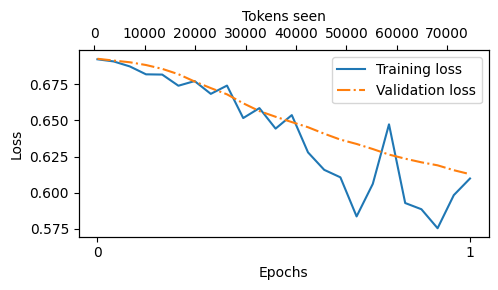

In [53]:
from previous_chapters import plot_losses
# 대안:
# from llms_from_scratch.ch05 import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(tracking["train_losses"]))
plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=tracking["train_losses"],
    val_losses=tracking["val_losses"],
    label="loss"
)

- 위에서 볼 수 있듯이 손실이 계속 개선되고 있으며, 이는 좋은 신호입니다.
- 하향 곡선을 보면 모델을 조금 더 훈련시키고 싶은 유혹이 들 수 있습니다 (독자분들도 시도해 보시길 권장합니다). 하지만 DPO는 모델이 엉뚱한 응답을 생성하기 시작하는 붕괴(collapse) 현상이 발생하기 쉽다는 점을 유의하세요.
- 다음으로, 보상 마진을 살펴보겠습니다:

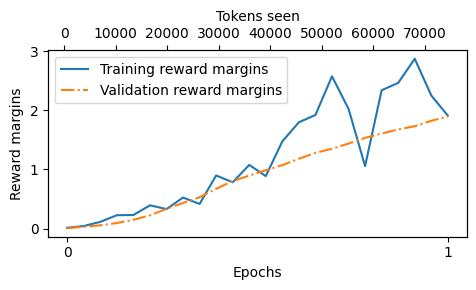

In [50]:
train_reward_margins = [i-j for i,j in zip(tracking["train_chosen_rewards"], tracking["train_rejected_rewards"])]
val_reward_margins = [i-j for i,j in zip(tracking["val_chosen_rewards"], tracking["val_rejected_rewards"])]

plot_losses(
    epochs_seen=epochs_tensor,
    tokens_seen=tracking["tokens_seen"],
    train_losses=train_reward_margins,
    val_losses=val_reward_margins,
    label="reward margins"
)

- 보시다시피 의도한 대로 보상 마진이 개선됩니다. 이는 손실 곡선과 거울상을 이루며 좋은 신호입니다.
- DPO 손실과 보상 마진은 훈련 중에 추적해야 할 중요한 지표이지만, 전체 이야기를 다 말해주지는 않습니다.
- 마지막으로, 가장 중요한 것은 응답에 대한 정성적인 확인을 수행해야 한다는 점입니다.
- 여기서는 응답을 직접 살펴볼 것입니다 (추가로 7장과 유사하게 LLM을 사용하여 응답에 점수를 매길 수도 있습니다).

In [51]:
torch.manual_seed(123)


for entry in val_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Correct response:
>> The meal is cooked by the chef every day.

Reference model response:
>> The meal is cooked every day by the chef.

Policy model response:
>> The active sentence could be replaced by the passive sentence: 'The chef prepares the meal every day.'

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Classify an input string as either a noun or a verb.

### Input:
Dance

Correct response:
>> 'Dance' can be classified as a verb.

Reference model response:
>> Dance is a verb.

Policy model response:
>> The input 'Dance' could be classified as a verb.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropr

- 위의 참조 모델(reference model)과 정책 모델(policy model)의 응답을 보면, 최적화된 모델(즉, 정책 모델)이 원래 모델(즉, 참조 모델)에 비해 스타일이 약간 변경되었음을 실제로 확인할 수 있습니다.
- 예를 들어, `"Dance" can be classified as a verb.`가 `The input string "Dance" could be classified as a verb.`로 변경되었는데, 이는 약간 더 정중한 응답입니다 ("can" 대신 "could"를 사용하여 주장을 덜 단정적이고 더 조심스럽게 표현했습니다).

In [52]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=reference_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    reference_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    token_ids = generate(
        model=policy_model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    policy_response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nReference model response:\n>> {reference_response_text.strip()}")
    print(f"\nPolicy model response:\n>> {policy_response_text.strip()}")
    print("\n-------------------------------------\n")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Reference model response:
>> The car is as fast as a bullet.

Policy model response:
>> The car would be very fast.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Reference model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.

Policy model response:
>> The type of cloud typically associated with thunderstorms is a cumulus.

-------------------------------------

Below is an instruction that describes a task. Write a response that app